Tracks after filtering: 70


,track_index,lifetime,max_size_points,env_ring_mean
0,156,4,275.0,0.014391
1,158,8,218.0,0.014109
2,160,3,263.0,0.014544
3,161,7,239.0,0.014312
4,162,4,8982.0,0.012875


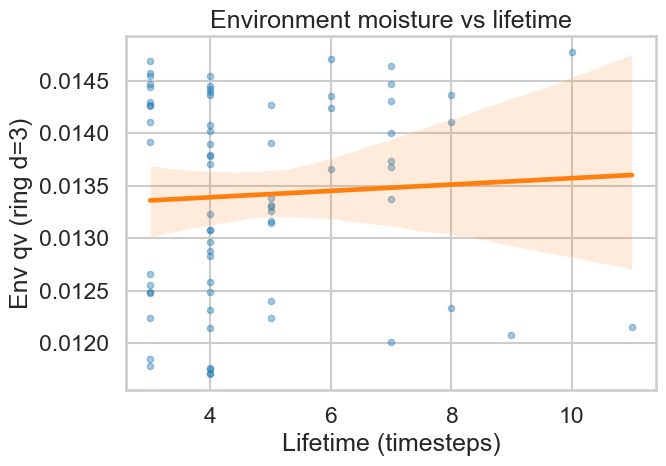

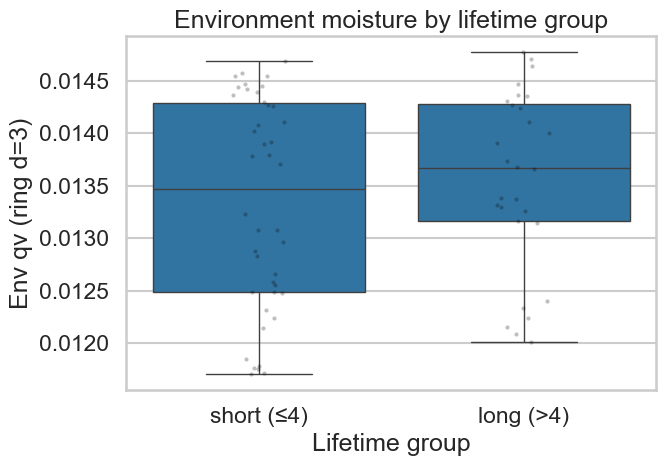

Mean environment moisture by group:
life_group
long (>4)     0.013550
short (≤4)    0.013324
Name: env_ring_mean, dtype: float64


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

# ---------------- Parameters ----------------
nc_file = "../cloud_results.nc"
min_max_size_points = 10   # track must reach at least this many voxels once
min_lifetime_steps = 3     # track must be present at least this many timesteps
ring_distance = 3          # 1..D; 1 = nearest environment ring
var_to_plot = "qv"         # "qv" (vapor) or "qt" (total water)

sns.set_context("talk")
sns.set_style("whitegrid")

# Safe display helper (works both in scripts and notebooks)
try:
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover
    def display(obj):
        print(obj)


# ---------------- Load data ----------------
with Dataset(nc_file) as ds:
    valid_track = np.asarray(ds.variables["valid_track"][:])  # (track,)
    size = np.ma.filled(ds.variables["size"][:], np.nan)      # (track,time)
    age = np.ma.filled(ds.variables["age"][:], -1)            # (track,time)
    height = np.asarray(ds.variables["height"][:])            # (level,)

    ring_var_name = f"env_{var_to_plot}_rings"
    if ring_var_name not in ds.variables:
        raise KeyError(f"Variable {ring_var_name} not found in file.")
    # (track,time,level,ring)
    env_rings = np.ma.filled(ds.variables[ring_var_name][:], np.nan)

# ---------------- Sanity on ring index ----------------
D = env_rings.shape[-1]
r_idx = int(ring_distance) - 1
if r_idx < 0 or r_idx >= D:
    raise ValueError(f"ring_distance out of bounds (1..{D})")

# ---------------- Build per-track table (full lifetimes only) ----------------
rows = []
n_tracks, n_time = size.shape
for i in range(n_tracks):
    if valid_track[i] != 1:
        continue

    present_t = age[i] >= 0
    if not np.any(present_t):
        continue

    # age starts at 0; max age + 1 is lifetime length in timesteps
    lifetime = int(np.nanmax(age[i][present_t])) + 1
    max_size = float(np.nanmax(size[i][present_t]))

    if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
        continue

    # Mean environment moisture across all levels and present timesteps at ring r_idx
    env_itl = env_rings[i, present_t, :, r_idx]  # (time_present, level)
    env_mean = float(np.nanmean(env_itl)) if env_itl.size > 0 else np.nan

    rows.append(
        dict(
            track_index=i,
            lifetime=lifetime,
            max_size_points=max_size,
            env_ring_mean=env_mean,
        )
    )

df = pd.DataFrame.from_records(rows)
print(f"Tracks after filtering: {len(df)}")
if df.empty:
    print("No data after filtering. Adjust thresholds and try again.")
    raise SystemExit(0)
else:
    display(df.head())

# Drop rows with missing env means for plotting/calcs
df_plot = df.dropna(subset=["env_ring_mean"]).copy()

# ---------------- Plots ----------------
if not df_plot.empty:
    # 1) Scatter with regression: environment moisture vs lifetime
    plt.figure(figsize=(7, 5))
    sns.regplot(
        data=df_plot,
        x="lifetime",
        y="env_ring_mean",
        scatter_kws=dict(alpha=0.4, s=20),
        line_kws=dict(color="C1"),
    )
    plt.xlabel("Lifetime (timesteps)")
    plt.ylabel(f"Env {var_to_plot} (ring d={ring_distance})")
    plt.title("Environment moisture vs lifetime")
    plt.tight_layout()
    plt.show()

    # 2) Compare shorter vs longer-lived (median split)
    thr = float(df_plot["lifetime"].median())
    df_plot["life_group"] = np.where(
        df_plot["lifetime"] <= thr,
        f"short (≤{int(thr)})",
        f"long (>{int(thr)})",
    )

    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df_plot, x="life_group", y="env_ring_mean")
    sns.stripplot(
        data=df_plot, x="life_group", y="env_ring_mean", color="k", alpha=0.25, size=3
    )
    plt.xlabel("Lifetime group")
    plt.ylabel(f"Env {var_to_plot} (ring d={ring_distance})")
    plt.title("Environment moisture by lifetime group")
    plt.tight_layout()
    plt.show()

    # 3) Simple group means printout
    print("Mean environment moisture by group:")
    print(df_plot.groupby("life_group")["env_ring_mean"].mean().round(6))
else:
    print("No finite env_ring_mean values available for plotting.")


Lifetime threshold: 5 min -> 5 timesteps
Tracks in groups -> long: 18, short: 52


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1403376058.py:30: RuntimeWarning: Mean of empty slice
  track_mean = np.nanmean(A, axis=0)  # (level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1403376058.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


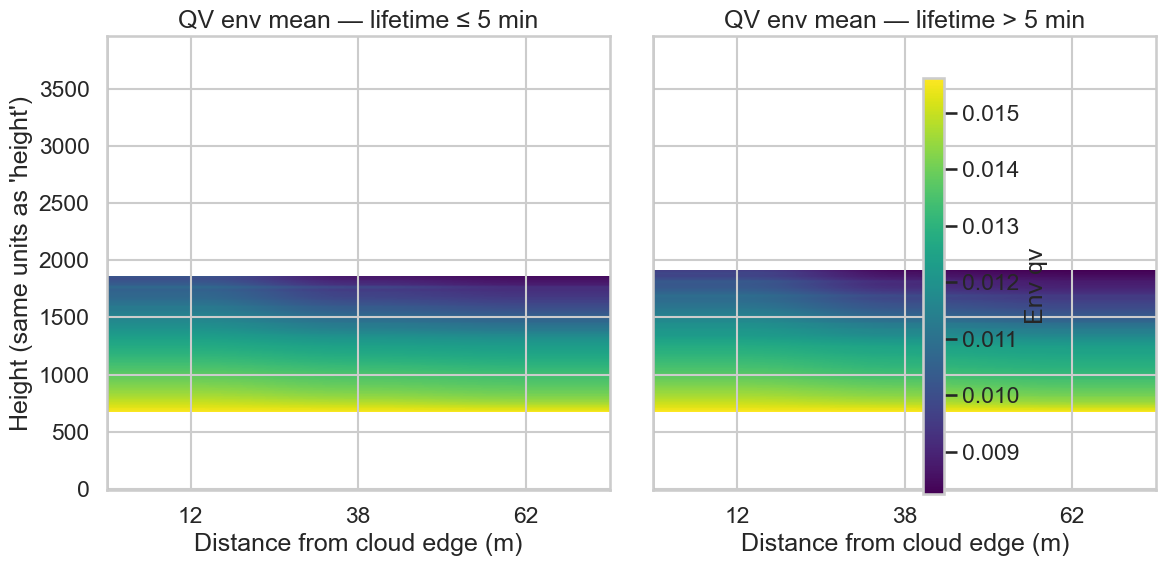

In [7]:
# ---------------- 2D mean environment by height and distance (two lifetime groups) ----------------
# Assumes the previous cell already loaded: ds -> env_rings, height, df with columns ['track_index','lifetime']
# Configure threshold and optional distance unit
threshold_minutes = 5
timestep_seconds = 60  # <-- SET THIS (e.g., 5.0). No 'time' var or dt attrs in file.
dx_m = 25             

if timestep_seconds is None:
    raise ValueError("Please set timestep_seconds (seconds per model step) to convert 5 minutes to steps.")

thr_steps = int(np.ceil((threshold_minutes * 60.0) / float(timestep_seconds)))
print(f"Lifetime threshold: {threshold_minutes} min -> {thr_steps} timesteps")

# Ring and height axes
n_levels = height.size
n_rings = env_rings.shape[-1]

# Build lifetime groups from df (already filtered for valid tracks)
lifetimes = df.set_index("track_index")["lifetime"]
idx_long = lifetimes[lifetimes > thr_steps].index.to_numpy()
idx_short = lifetimes[lifetimes <= thr_steps].index.to_numpy()
print(f"Tracks in groups -> long: {len(idx_long)}, short: {len(idx_short)}")

def group_mean_equal_per_track(track_indices):
    # Average per track across time first, then average across tracks
    sum_arr = np.zeros((n_levels, n_rings), dtype=np.float64)
    count_arr = np.zeros((n_levels, n_rings), dtype=np.float64)
    for i in track_indices:
        A = env_rings[i, :, :, :]  # (time, level, ring); inactive times are NaN
        track_mean = np.nanmean(A, axis=0)  # (level, ring)
        mask = np.isfinite(track_mean)
        sum_arr[mask] += track_mean[mask]
        count_arr[mask] += 1.0
    with np.errstate(invalid="ignore", divide="ignore"):
        out = sum_arr / count_arr
    return out

mean_short = group_mean_equal_per_track(idx_short) if len(idx_short) > 0 else np.full((n_levels, n_rings), np.nan)
mean_long  = group_mean_equal_per_track(idx_long)  if len(idx_long)  > 0 else np.full((n_levels, n_rings), np.nan)

# Common color scale
vals = np.concatenate([
    mean_short[np.isfinite(mean_short)].ravel(),
    mean_long[np.isfinite(mean_long)].ravel()
]) if (np.any(np.isfinite(mean_short)) or np.any(np.isfinite(mean_long))) else np.array([])
if vals.size == 0:
    raise SystemExit("No finite values to plot after grouping.")
vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))

# Axes extent and ticks
if dx_m is None:
    x_left, x_right = 0.0, float(n_rings)
    x_label = "Distance from cloud edge (rings)"
    x_tick_centers = np.arange(n_rings) + 0.5
    x_tick_labels = [str(i) for i in range(1, n_rings + 1)]
else:
    x_left, x_right = 0.0, float(n_rings) * float(dx_m)
    x_label = f"Distance from cloud edge (m)"
    x_tick_centers = (np.arange(n_rings) + 0.5) * float(dx_m)
    x_tick_labels = [f"{int(round(c))}" for c in x_tick_centers]

y_bottom, y_top = float(np.nanmin(height)), float(np.nanmax(height))
extent = (x_left, x_right, y_bottom, y_top)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
titles = [
    f"{var_to_plot.upper()} env mean — lifetime ≤ {threshold_minutes} min",
    f"{var_to_plot.upper()} env mean — lifetime > {threshold_minutes} min",
]
data = [mean_short, mean_long]

for ax, arr, title in zip(axes, data, titles):
    im = ax.imshow(arr.T if False else arr,  # arr is (level, ring). imshow expects (Y, X) => (level, ring)
                   origin="lower", aspect="auto", extent=extent,
                   vmin=vmin, vmax=vmax, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_xticks(x_tick_centers)
    ax.set_xticklabels(x_tick_labels)
    ax.axvline(0.0, color="k", lw=1)  # cloud edge at x=0

axes[0].set_ylabel("Height (same units as 'height')")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, label=f"Env {var_to_plot}")
plt.tight_layout()
plt.show()


Lifetime threshold: 5 min -> 5 timesteps
Tracks in groups → long: 18, short: 52


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1225605383.py:85: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1225605383.py:85: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1225605383.py:85: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1225605383.py:85: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/1225605383.py:85: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_3

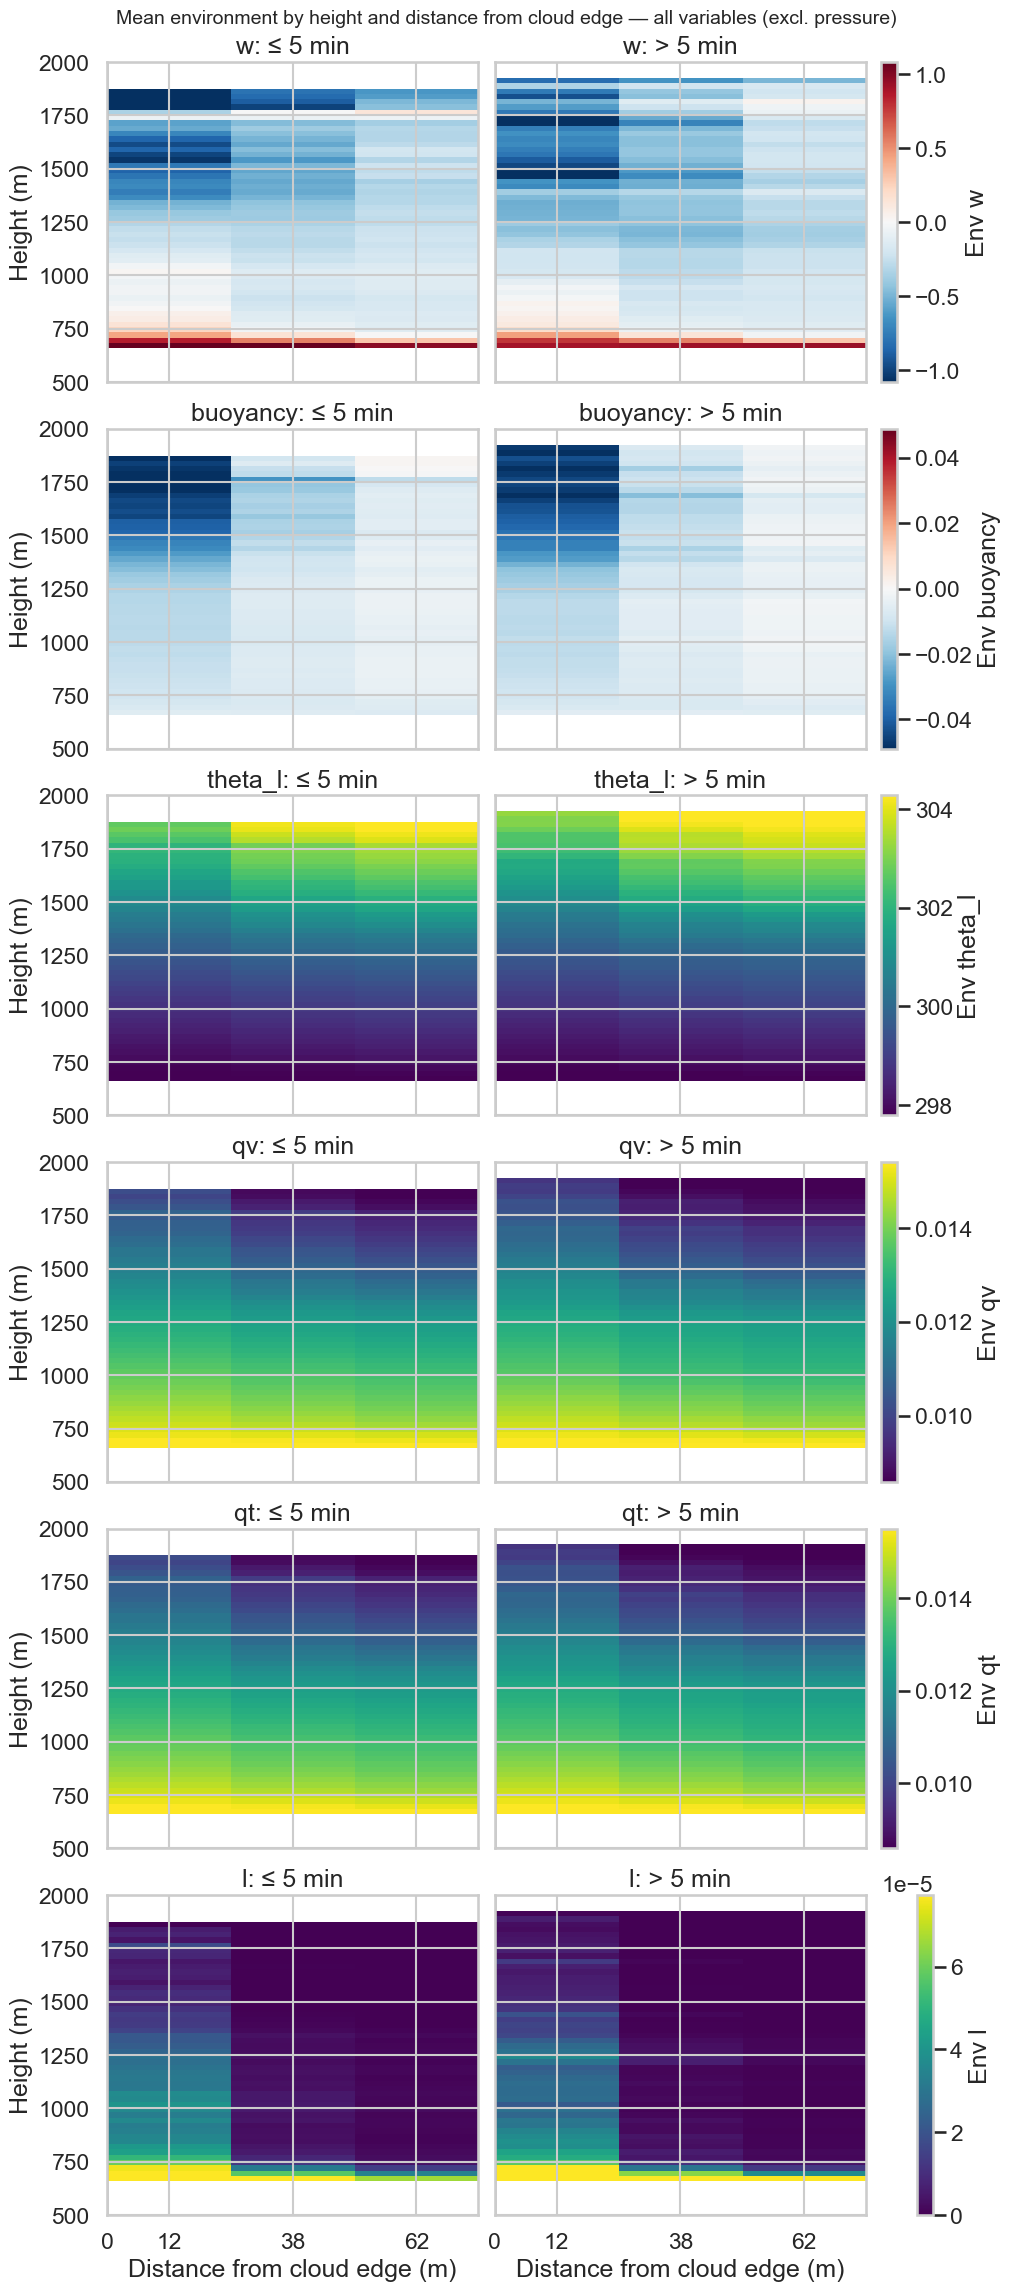

In [9]:
# ==== Configure threshold and axes ====
threshold_minutes = 5
timestep_seconds = 60  # <-- SET THIS (e.g., 30.0). Needed to convert minutes -> steps.
dx_m = 25              # Optional: horizontal grid spacing for x-axis in meters (else shows ring indices)

if timestep_seconds is None:
    raise ValueError("Please set timestep_seconds (seconds per model step).")

thr_steps = int(np.ceil((threshold_minutes * 60.0) / float(timestep_seconds)))
print(f"Lifetime threshold: {threshold_minutes} min -> {thr_steps} timesteps")

# Variables to plot: (netCDF var name, short label, default cmap, diverging?)
# Removed pressure ("env_p_rings", "p", ...)
var_specs = [
    ("env_w_rings",          "w",         "RdBu_r", True),
    ("env_buoyancy_rings",   "buoyancy",  "RdBu_r", True),
    ("env_theta_l_rings",    "theta_l",   "viridis", False),
    ("env_qv_rings",         "qv",        "viridis", False),
    ("env_qt_rings",         "qt",        "viridis", False),
    ("env_l_rings",          "l",         "viridis", False),
]

# ==== Ensure we have df with lifetimes and track indices ====
def build_track_df_from_arrays(valid_track, size, age, min_max_size_points=10, min_lifetime_steps=3):
    rows = []
    n_tracks, _ = size.shape
    for i in range(n_tracks):
        if valid_track[i] != 1:
            continue
        present_t = age[i] >= 0
        if not np.any(present_t):
            continue
        lifetime = int(np.nanmax(age[i][present_t])) + 1  # age starts at 0
        max_size = float(np.nanmax(size[i][present_t]))
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue
        rows.append(dict(track_index=i, lifetime=lifetime, max_size_points=max_size))
    return pd.DataFrame.from_records(rows)

# If df is missing, rebuild it from arrays already in memory (size, age, valid_track), or read them from file.
try:
    _ = df["track_index"]
    _ = df["lifetime"]
except Exception:
    print("Rebuilding df (filtered tracks)...")
    try:
        valid_track, size, age  # already loaded in earlier cell?
    except NameError:
        with Dataset(nc_file) as ds:
            valid_track = np.asarray(ds.variables["valid_track"][:])
            size = np.ma.filled(ds.variables["size"][:], np.nan)
            age  = np.ma.filled(ds.variables["age"][:],  -1)
    df = build_track_df_from_arrays(valid_track, size, age)

if df.empty:
    raise SystemExit("No tracks after filtering; adjust thresholds and retry.")

# Lifetime groups
lifetimes = df.set_index("track_index")["lifetime"]
idx_long  = lifetimes[lifetimes > thr_steps].index.to_numpy()
idx_short = lifetimes[lifetimes <= thr_steps].index.to_numpy()
print(f"Tracks in groups → long: {len(idx_long)}, short: {len(idx_short)}")

# ==== Helpers for chunked group means ====
def group_mean_equal_per_track_nc(nc_path, var_name, track_indices, chunk_size=512):
    if len(track_indices) == 0:
        return None, None  # shape will be inferred by caller

    with Dataset(nc_path) as ds:
        var = ds.variables[var_name]
        n_levels = ds.dimensions["level"].size
        n_rings  = ds.dimensions["ring"].size
        sum_arr = np.zeros((n_levels, n_rings), dtype=np.float64)
        cnt_arr = np.zeros((n_levels, n_rings), dtype=np.float64)

        # Sort for efficient slicing; order doesn't matter for sums
        inds = np.array(track_indices, dtype=int)
        inds.sort()

        for s in range(0, len(inds), chunk_size):
            chunk = inds[s:s+chunk_size]
            data = var[chunk, :, :, :]  # (chunk, time, level, ring), masked ok
            if hasattr(data, "filled"):
                data = data.filled(np.nan)
            track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
            # accumulate across tracks
            sum_arr += np.nansum(track_time_mean, axis=0)
            cnt_arr += np.sum(np.isfinite(track_time_mean), axis=0)

        with np.errstate(invalid="ignore", divide="ignore"):
            mean_arr = sum_arr / cnt_arr
        mean_arr[~np.isfinite(mean_arr)] = np.nan
        return mean_arr, (n_levels, n_rings)

# Build axes extents and ticks
def axes_geom(n_rings, height, dx_m=None):
    y_bottom, y_top = float(np.nanmin(height)), float(np.nanmax(height))
    if dx_m is None:
        extent = (0.0, float(n_rings), y_bottom, y_top)
        x_label = "Distance from cloud edge (rings)"
        xticks = [0.0] + (np.arange(n_rings) + 0.5).tolist()
        xticklabels = ["0"] + [str(i) for i in range(1, n_rings + 1)]
    else:
        extent = (0.0, float(n_rings) * float(dx_m), y_bottom, y_top)
        x_label = "Distance from cloud edge (m)"
        centers = (np.arange(n_rings) + 0.5) * float(dx_m)
        xticks = [0.0] + centers.tolist()
        xticklabels = ["0"] + [f"{int(round(c))}" for c in centers]
    return extent, x_label, xticks, xticklabels

# ==== Compute and plot ====
# Get height and ring count
with Dataset(nc_file) as ds:
    height_nc = np.asarray(ds.variables["height"][:])
    n_rings_nc = ds.dimensions["ring"].size

# Use previously loaded height if available, else from file
height_vec = height if "height" in globals() else height_nc
extent, x_label, xticks, xticklabels = axes_geom(n_rings_nc, height_vec, dx_m=dx_m)

nrows = len(var_specs)

# Make plots taller and less wide; use constrained_layout to keep colorbars OUTSIDE axes
fig, axes = plt.subplots(
    nrows, 2,
    figsize=(10, max(3.8 * nrows, 10)),  # taller, less wide
    sharex=True, sharey=True,
    constrained_layout=True
)
if nrows == 1:
    axes = np.array([axes])  # ensure 2D

for r, (var_name, short, cmap, is_div) in enumerate(var_specs):
    # Compute group means
    mean_short, shape = group_mean_equal_per_track_nc(nc_file, var_name, idx_short)
    mean_long,  _     = group_mean_equal_per_track_nc(nc_file, var_name, idx_long)

    if shape is None:
        # No tracks in either group → blank panels
        mean_short = np.full((len(height_vec), n_rings_nc), np.nan)
        mean_long  = np.full((len(height_vec), n_rings_nc), np.nan)

    # Color scale (robust percentiles across both groups)
    vals = np.concatenate([
        mean_short[np.isfinite(mean_short)].ravel(),
        mean_long[np.isfinite(mean_long)].ravel()
    ]) if (np.any(np.isfinite(mean_short)) or np.any(np.isfinite(mean_long))) else np.array([])
    if vals.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = np.nanpercentile(vals, [2, 98])
        if is_div:
            m = max(abs(vmin), abs(vmax))
            vmin, vmax = -m, m

    # Plot two panels (short, long)
    panels = [(axes[r, 0], mean_short, f"≤ {threshold_minutes} min"),
              (axes[r, 1], mean_long,  f"> {threshold_minutes} min")]
    ims = []
    for ax, arr, title in panels:
        im = ax.imshow(
            arr, origin="lower", aspect="auto", extent=extent,
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        ims.append(im)
        ax.set_title(f"{short}: {title}")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=0)
        ax.axvline(0.0, color="k", lw=1)

        # Cut off y-axis between 500 and 2000 m
        ax.set_ylim(500, 2000)

    # Row-wise colorbar OUTSIDE the plots
    cbar = fig.colorbar(
        ims[0],
        ax=axes[r, :].ravel().tolist(),
        location="right",
        pad=0.02,          # space between axes and colorbar
        fraction=0.05      # relative size of colorbar
    )
    cbar.set_label(f"Env {short}")

# Labels
for ax in axes[-1, :]:
    ax.set_xlabel(x_label)
axes[0, 0].set_ylabel("Height (m)")
for rr in range(1, nrows):
    axes[rr, 0].set_ylabel("Height (m)")

fig.suptitle(
    "Mean environment by height and distance from cloud edge — all variables (excl. pressure)",
    fontsize=14
)

plt.show()


Lifetime threshold: 5 min -> 5 timesteps
Tracks in groups → long: 18, short: 52


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/3635668202.py:90: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/3635668202.py:90: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/3635668202.py:90: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/3635668202.py:90: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_31247/3635668202.py:90: RuntimeWarning: Mean of empty slice
  track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_3

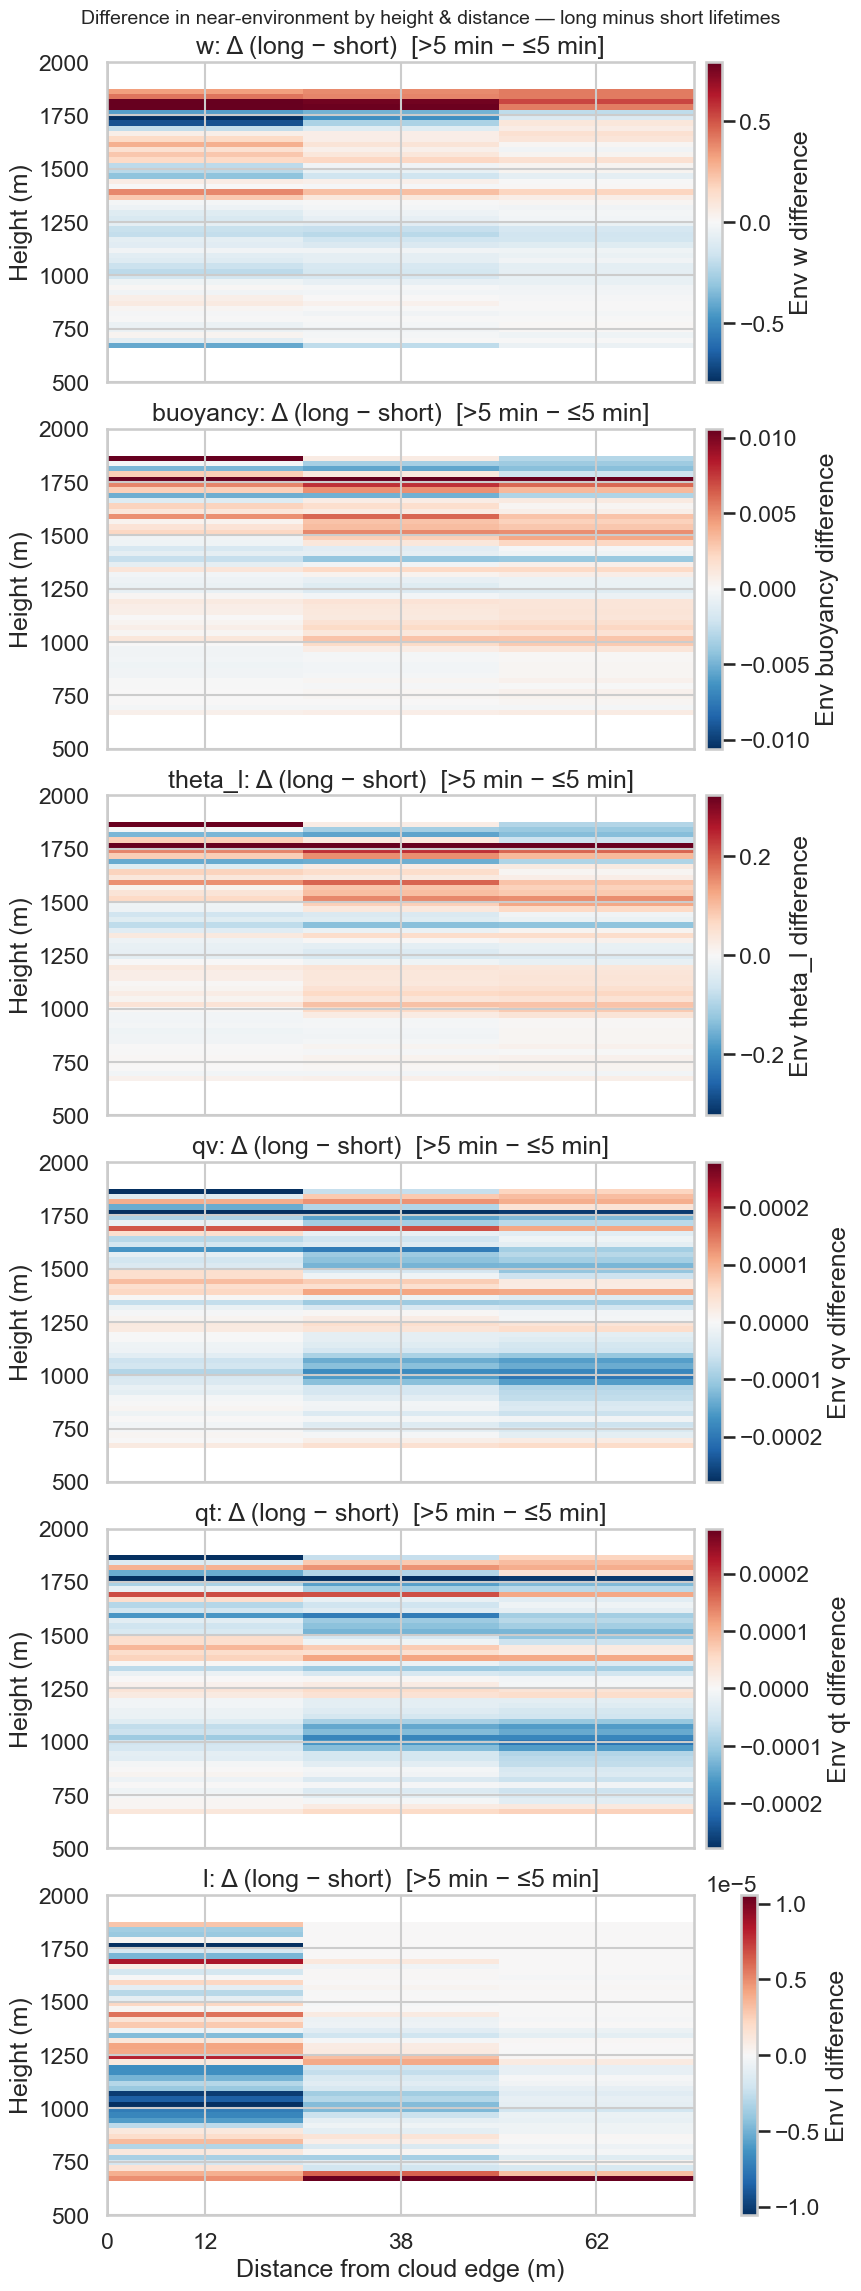

In [ ]:
# ==== Configure threshold and axes ====
threshold_minutes = 5
timestep_seconds = 60  
dx_m = 25          

# Fallback for nc_file if not already defined earlier
try:
    nc_file
except NameError:
    nc_file = "../cloud_results.nc"

if timestep_seconds is None:
    raise ValueError("Please set timestep_seconds (seconds per model step).")

thr_steps = int(np.ceil((threshold_minutes * 60.0) / float(timestep_seconds)))
print(f"Lifetime threshold: {threshold_minutes} min -> {thr_steps} timesteps")

# Variables to plot: (netCDF var name, short label, default cmap, diverging?)
# Pressure removed.
var_specs = [
    ("env_w_rings",          "w",         "RdBu_r", True),
    ("env_buoyancy_rings",   "buoyancy",  "RdBu_r", True),
    ("env_theta_l_rings",    "theta_l",   "viridis", False),
    ("env_qv_rings",         "qv",        "viridis", False),
    ("env_qt_rings",         "qt",        "viridis", False),
    ("env_l_rings",          "l",         "viridis", False),
]

# ==== Ensure we have df with lifetimes and track indices ====
def build_track_df_from_arrays(valid_track, size, age, min_max_size_points=10, min_lifetime_steps=3):
    rows = []
    n_tracks, _ = size.shape
    for i in range(n_tracks):
        if valid_track[i] != 1:
            continue
        present_t = age[i] >= 0
        if not np.any(present_t):
            continue
        lifetime = int(np.nanmax(age[i][present_t])) + 1  # age starts at 0
        max_size = float(np.nanmax(size[i][present_t]))
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue
        rows.append(dict(track_index=i, lifetime=lifetime, max_size_points=max_size))
    return pd.DataFrame.from_records(rows)

# If df is missing, rebuild it from arrays already in memory (size, age, valid_track), or read them from file.
try:
    _ = df["track_index"]
    _ = df["lifetime"]
except Exception:
    print("Rebuilding df (filtered tracks)...")
    try:
        valid_track, size, age  # already loaded in earlier cell?
    except NameError:
        with Dataset(nc_file) as ds:
            valid_track = np.asarray(ds.variables["valid_track"][:])
            size = np.ma.filled(ds.variables["size"][:], np.nan)
            age  = np.ma.filled(ds.variables["age"][:],  -1)
    df = build_track_df_from_arrays(valid_track, size, age)

if df.empty:
    raise SystemExit("No tracks after filtering; adjust thresholds and retry.")

# Lifetime groups
lifetimes = df.set_index("track_index")["lifetime"]
idx_long  = lifetimes[lifetimes > thr_steps].index.to_numpy()
idx_short = lifetimes[lifetimes <= thr_steps].index.to_numpy()
print(f"Tracks in groups → long: {len(idx_long)}, short: {len(idx_short)}")

# ==== Helpers for chunked group means ====
def group_mean_equal_per_track_nc(nc_path, var_name, track_indices, chunk_size=512):
    if len(track_indices) == 0:
        return None, None  # shape will be inferred by caller

    with Dataset(nc_path) as ds:
        var = ds.variables[var_name]
        n_levels = ds.dimensions["level"].size
        n_rings  = ds.dimensions["ring"].size
        sum_arr = np.zeros((n_levels, n_rings), dtype=np.float64)
        cnt_arr = np.zeros((n_levels, n_rings), dtype=np.float64)

        inds = np.array(track_indices, dtype=int)
        inds.sort()

        for s in range(0, len(inds), chunk_size):
            chunk = inds[s:s+chunk_size]
            data = var[chunk, :, :, :]  # (chunk, time, level, ring)
            if hasattr(data, "filled"):
                data = data.filled(np.nan)
            track_time_mean = np.nanmean(data, axis=1)  # (chunk, level, ring)
            sum_arr += np.nansum(track_time_mean, axis=0)
            cnt_arr += np.sum(np.isfinite(track_time_mean), axis=0)

        with np.errstate(invalid="ignore", divide="ignore"):
            mean_arr = sum_arr / cnt_arr
        mean_arr[~np.isfinite(mean_arr)] = np.nan
        return mean_arr, (n_levels, n_rings)

# Build axes extents and ticks
def axes_geom(n_rings, height, dx_m=None):
    y_bottom, y_top = float(np.nanmin(height)), float(np.nanmax(height))
    if dx_m is None:
        extent = (0.0, float(n_rings), y_bottom, y_top)
        x_label = "Distance from cloud edge (rings)"
        xticks = [0.0] + (np.arange(n_rings) + 0.5).tolist()
        xticklabels = ["0"] + [str(i) for i in range(1, n_rings + 1)]
    else:
        extent = (0.0, float(n_rings) * float(dx_m), y_bottom, y_top)
        x_label = "Distance from cloud edge (m)"
        centers = (np.arange(n_rings) + 0.5) * float(dx_m)
        xticks = [0.0] + centers.tolist()
        xticklabels = ["0"] + [f"{int(round(c))}" for c in centers]
    return extent, x_label, xticks, xticklabels, y_bottom, y_top

# ==== Compute and plot ====
# Get height and ring count
with Dataset(nc_file) as ds:
    height_nc = np.asarray(ds.variables["height"][:])
    n_rings_nc = ds.dimensions["ring"].size

# Use previously loaded height if available, else from file
height_vec = height if "height" in globals() else height_nc
extent, x_label, xticks, xticklabels, y_bottom, y_top = axes_geom(n_rings_nc, height_vec, dx_m=dx_m)

# Y-axis clip to requested range, but respect data bounds
ymin_clip = max(500.0, y_bottom)
ymax_clip = min(2000.0, y_top)

nrows = len(var_specs)

# One column: show DIFFERENCE (long - short). Taller, less wide. Keep cbar outside.
fig, axes = plt.subplots(
    nrows, 1,
    figsize=(8.5, max(3.8 * nrows, 10)),
    sharex=True, sharey=True,
    constrained_layout=True
)
if nrows == 1:
    axes = np.array([axes])  # ensure 1D ndarray

for r, (var_name, short, _cmap_unused, _is_div_unused) in enumerate(var_specs):
    # Compute group means
    mean_short, shape = group_mean_equal_per_track_nc(nc_file, var_name, idx_short)
    mean_long,  _     = group_mean_equal_per_track_nc(nc_file, var_name, idx_long)

    if shape is None:
        diff_arr = np.full((len(height_vec), n_rings_nc), np.nan)
    else:
        # Difference = long - short
        diff_arr = mean_long - mean_short

    # Robust symmetric color limits around zero using |values|
    finite_vals = diff_arr[np.isfinite(diff_arr)]
    if finite_vals.size == 0:
        vmax = 1.0
    else:
        vmax = np.nanpercentile(np.abs(finite_vals), 98)
        if not np.isfinite(vmax) or vmax == 0:
            vmax = np.nanmax(np.abs(finite_vals)) if finite_vals.size else 1.0
            if vmax == 0:
                vmax = 1.0
    vmin = -vmax

    ax = axes[r]
    im = ax.imshow(
        diff_arr, origin="lower", aspect="auto", extent=extent,
        vmin=vmin, vmax=vmax, cmap="RdBu_r"  # diverging for differences
    )
    ax.set_title(f"{short}: Δ (long − short)  [>{threshold_minutes} min − ≤{threshold_minutes} min]")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.axvline(0.0, color="k", lw=1)
    ax.set_ylim(ymin_clip, ymax_clip)

    # Colorbar per row, outside the axis
    cbar = fig.colorbar(
        im, ax=ax, location="right", pad=0.02, fraction=0.05
    )
    cbar.set_label(f"Env {short} difference")

# Labels
axes[-1].set_xlabel(x_label)
for ax in axes:
    ax.set_ylabel("Height (m)")

fig.suptitle(
    "Difference in near-environment by height & distance — long minus short lifetimes",
    fontsize=14
)
plt.show()
